# Model Optimization using Adam

The purpose of this notebook is to present a workflow to optimize the training of a model using NWPU-Resic45 lake images and corresponding labels for the purposes of estimating lake area over time at sites represented in the Sentinel-2 imagery.

All models have been trained using `Adam` as the model's optimization algorithm.

## External Dependencies

In [1]:
colab = True

In [ ]:
if colab:
    !pip install rasterio
    #!pip install --default-timeout=1000 tensorflow-gpu==2.3

## Requirements

In [3]:
import os
import sys
module_path = os.path.abspath('deep-water')
if module_path not in sys.path:
    sys.path.append(module_path)

Import remaining dependencies.

In [49]:
import glob
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pprint
import rasterio
import random
import shutil
import tensorflow as tf
from metrics.diceLoss import dice_coef, dice_coef_loss
from metrics.jaccardIndex import mean_iou, iou_loss
from models.batchLoader import BatchLoader
from models.dataAugmentationLoader import DataAugmentationLoader
from models.callbacks import build_callbacks
from models.unet import Unet
from models.unetResidual import UnetResidual
from PIL import Image, ImageDraw
from tools.google_drive_downloader import GoogleDriveDownloader
%matplotlib inline

Verify if the notebook contains the expected Tensorflow version.

In [50]:
print("tensorflow version: ", tf.__version__)
assert tf.__version__ == '2.3.0'

tensorflow version:  2.3.0


Verify if there is a GPU allocated running in the background.

In [51]:
devices = tf.config.list_physical_devices('GPU')
assert type(devices[0]) == tf.python.eager.context.PhysicalDevice

The constants used in this notebook are defined as follows.

In [52]:
batch_size = 8
epochs = 200
image_size = (256, 256)
patience_early_stopping = 20
patience_reduce_lr_on_plateau = 10
model_optimizer = 'adam'
baseline_file_id = '14vL-3083qM-MTjsZq-Xt3Rc0Nn7u6raP'
baseline_file_name = 'baseline_20200921.zip'
nwpu_image_train_folder = 'nwpu_images_train'
nwpu_mask_train_folder = 'nwpu_label_images_train'
nwpu_image_validation_folder = 'nwpu_images_validation'
nwpu_mask_validation_folder = 'nwpu_label_images_validation'
s2cloudless_image_folder = 's2cloudless_imagery'
s2cloudless_mask_folder = 's2cloudless_label_imagery'
histories = {}
results = {}

Download training and test datasets.

In [53]:
google_drive_downloader = GoogleDriveDownloader()
google_drive_downloader.download(baseline_file_id, baseline_file_name, True)

uncompressing baseline_20200921.zip... Done.
downloading baseline_20200921.zip... Done.


Remove temporary folder and file.

In [54]:
shutil.rmtree('__MACOSX')
os.remove(baseline_file_name)

## Helper Functions

Define a function to display the training history.

In [55]:
def plot_history(model_history, metric='mean_iou'):
    label = 'Mean IoU' if metric == 'mean_iou' else 'Validation Dice Coef'
    plt.figure(figsize=(10, 4))
    # Mean IoU
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history[metric], label="train")
    plt.plot(model_history.history[f'val_{metric}'], label="validation")
    plt.ylim(0, 1)
    plt.axhline(y=0.85, color='r', linestyle='dashed')
    plt.title(f'{label} vs Epoch Number')
    plt.ylabel(label)
    plt.xlabel('Epoch number')
    plt.legend(loc='lower right')
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label="train")
    plt.plot(model_history.history['val_loss'], label="validation")
    plt.legend()
    plt.title("Loss vs Epoch Number")
    plt.ylabel('Loss')
    plt.xlabel('Epoch number')
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

Define a function to display six samples of the training data.

In [56]:
def display_training_samples(batch_size, X):
    index = 1
    table_size = 6
    images_count = batch_size if batch_size < table_size else table_size
    plt.figure(figsize=(20, 2))
    for i in range(images_count):
        plt.subplot(1, images_count, index)
        plt.imshow(X_sample[i])
        index += 1
    plt.show()
    plt.close()

Save model training history on the disk.

In [57]:
def save_model_history(model_name, model_history):
    file_name = f'history_{model_name}.bin'
    pair_name_history = {model_name: model_history.history}
    with open(file_name, 'wb') as file:
        pickle.dump(pair_name_history, file)

Display model metrics.

In [58]:
def display_model_metrics(metrics):
    if 'dice' in model_name:
        print('Dice coeficient loss: {}'.format(metrics[0]))
        print('Dice coeficient: {}'.format(metrics[1]))
    else:
        print('Loss: {}'.format(metrics[0]))
        print('IoU: {}'.format(metrics[1]))
        print('IoU loss: {}'.format(metrics[2]))
        print('Dice coeficient: {}'.format(metrics[3]))
        print('Dice coeficient loss: {}'.format(metrics[4]))

Save mode metrics.

In [59]:
def save_model_metrics(model_name, metrics):
    if 'dice' in model_name:
        results[model_name] = {
            'dice_coef':metrics[0],
            'dice_coef_loss':metrics[1]
        }
    else:
        results[model_name] = {
            'loss':metrics[0],
            'iou':metrics[1],
            'iou_loss':metrics[2],
            'dice_coef':metrics[3],
            'dice_coef_loss':metrics[4]
        }

Define a function to display a list of training history.

In [60]:
def plot_histories(model_histories, metric='mean_iou'):
    label = 'Validation IoU' if metric == 'mean_iou' else 'Validation Dice Coef'
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    for title, history in model_histories.items():
        plt.plot(history.history[f'val_{metric}'], label=title)
        plt.ylim(0, 1)
        plt.title(f'{label} vs Epoch Number')
        plt.ylabel(label)
        plt.xlabel('Epoch number')
    plt.subplot(1, 2, 2)
    for title, history in model_histories.items():
        plt.plot(history.history["val_loss"], label=title)
        plt.title("Loss vs Epoch Number")
        plt.ylabel('Loss')
        plt.xlabel('Epoch number')
        plt.legend(loc='upper right')
    plt.show()
    plt.close()

Define a function to build the model's callbacks.

In [61]:
def build_callback_parameters(model_name, metric='val_loss'):
    callback_parameters = {}
    enable_csv_logger = False
    callback_reduce_lr_on_plateau = {
        'cooldown':5,
        'factor':0.2,
        'min_lr':0.0001,
        'min_delta':0.0001,
        'monitor':metric,
        'patience':patience_reduce_lr_on_plateau
    }
    if metric == 'val_loss':
        callback_parameters = {
            'model_name':model_name,
            'enable_csv_logger':enable_csv_logger,
            'early_stopping':{'mode':'min', 'monitor':'val_loss', 'patience':patience_early_stopping},
            'reduce_lr_on_plateau':callback_reduce_lr_on_plateau
        }
    elif metric == 'val_dice_coef':
        callback_parameters = {
            'model_name':model_name,
            'enable_csv_logger':enable_csv_logger,
            'reduce_lr_on_plateau':callback_reduce_lr_on_plateau
        }
    return callback_parameters

Defines a function to split the dataset into training, validation and test and display the number of the images for each dataset as well as the batch size.

In [62]:
def get_number_of_training_steps():
    # training
    train_files = glob.glob(os.path.join(nwpu_image_train_folder, 'data', '*.jpg'))
    train_file_count = len(train_files)
    train_steps = train_file_count // batch_size
    # validation
    validation_files = glob.glob(os.path.join(nwpu_image_validation_folder, 'data', '*.jpg'))
    validation_file_count = len(validation_files)
    validation_steps = validation_file_count // batch_size
    # display the number of images for each dataset as well as the batch size
    print("# training steps: {}".format(train_steps))
    print("# validation steps: {}".format(validation_steps))
    print("# batch size: {}".format(batch_size))
    return (train_steps, validation_steps)

Defines a function that creates a generator object for the training, validation and test datasets in order to feed the neural network.

In [63]:
def build_generators():
    test_files = glob.glob(os.path.join(s2cloudless_image_folder, 'data', '*.jpg'))
    test_file_count = len(test_files)
    test_loader = BatchLoader(test_files, s2cloudless_image_folder, s2cloudless_mask_folder, test_file_count, image_size)
    test_generator = test_loader()
    print("Test:")
    print("Found {} images.".format(test_file_count))
    train_loader = DataAugmentationLoader(nwpu_image_train_folder, nwpu_mask_train_folder, batch_size, image_size)
    print("Training:")
    train_generator = train_loader()
    validation_loader = DataAugmentationLoader(nwpu_image_validation_folder, nwpu_mask_validation_folder, batch_size, image_size)
    print("Validation:")
    validation_generator = validation_loader()
    return (train_generator, validation_generator, test_generator)

## Training Tuning Strategies

The following strategies will be explored in this section:
1. Using Early Stopping and Adaptive Learning Rates;
2. Using a bigger model (and dropout);
3. Using regularization (Batch Normalization);
4. Using residual connections;
4. Dealing with class imbalance using dice loss;
6. Refining label images using CRFs;
7. Ensemble predictions.

### Optimization strategy 1: Create a baseline model with Early Stopping and Adaptive Learning Rates

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [64]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

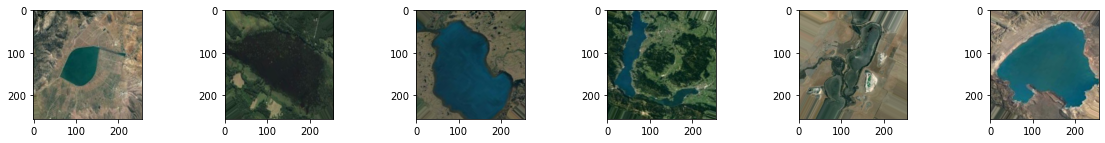

In [65]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Display a few samples from the validation dataset

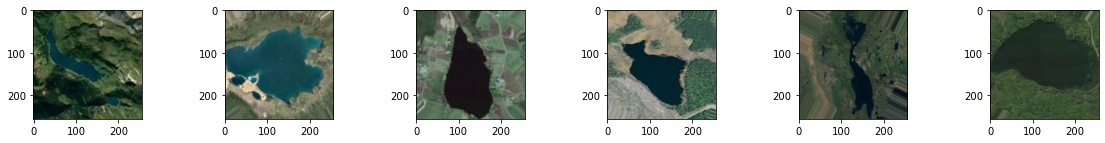

In [66]:
X_sample, Y_sample = next(validation_generator)
display_training_samples(batch_size, X_sample)

#### Display a few samples from the test dataset

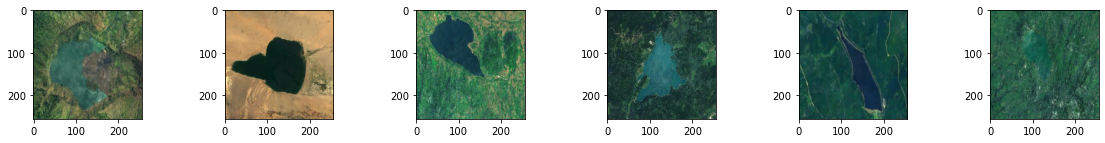

In [67]:
X_sample, Y_sample = next(test_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [68]:
unet_baseline = Unet('unet-baseline', image_size)
model_name = unet_baseline.model_name
unet_baseline.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

The summary of the model architecture that will be used for the baseline can be find detailed below.

In [69]:
unet_baseline.get_model_summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 8)  584         conv2d_54[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_55[0][0]                  
_______________________________________________________________________________________

#### Evaluating the model before training

In [70]:
X_test, Y_test = next(test_generator)
metrics = unet_baseline.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.692501425743103
IoU: 0.04143952205777168
IoU loss: 0.9585604071617126
Dice coeficient: 0.25311148166656494
Dice coeficient loss: 0.7468884587287903


#### Setup callbacks and fit the model

In [71]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_baseline.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_baseline.history

Epoch 1/200
61/61 [==============================] - 14s 226ms/step - loss: 0.5252 - mean_iou: 0.0012 - iou_loss: 0.9988 - dice_coef: 0.2894 - dice_coef_loss: 0.7106 - val_loss: 1.3189 - val_mean_iou: 0.2592 - val_iou_loss: 0.7408 - val_dice_coef: 0.3925 - val_dice_coef_loss: 0.6075
Epoch 2/200
61/61 [==============================] - 14s 224ms/step - loss: 0.4162 - mean_iou: 0.0115 - iou_loss: 0.9885 - dice_coef: 0.3647 - dice_coef_loss: 0.6353 - val_loss: 0.3815 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.4189 - val_dice_coef_loss: 0.5811
Epoch 3/200
61/61 [==============================] - 14s 227ms/step - loss: 0.3548 - mean_iou: 0.1829 - iou_loss: 0.8171 - dice_coef: 0.4347 - dice_coef_loss: 0.5653 - val_loss: 0.3547 - val_mean_iou: 0.5699 - val_iou_loss: 0.4301 - val_dice_coef: 0.4422 - val_dice_coef_loss: 0.5578
Epoch 4/200
61/61 [==============================] - 14s 226ms/step - loss: 0.3314 - mean_iou: 0.5303 - iou_loss: 0.4697 - dice_coef: 0.4669 - d

#### Inspect and save the history

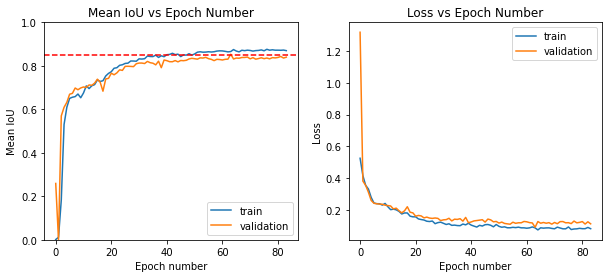

In [72]:
plot_history(unet_baseline.history)
save_model_history(model_name, unet_baseline.history)

#### Evaluating the model after training

In [73]:
metrics = unet_baseline.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.21110928058624268
IoU: 0.659829318523407
IoU loss: 0.34017065167427063
Dice coeficient: 0.754050076007843
Dice coeficient loss: 0.2459498643875122


Delete the model.

In [74]:
del unet_baseline

### Optimization strategy 2: Changing model architecture using a bigger rocket

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [75]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

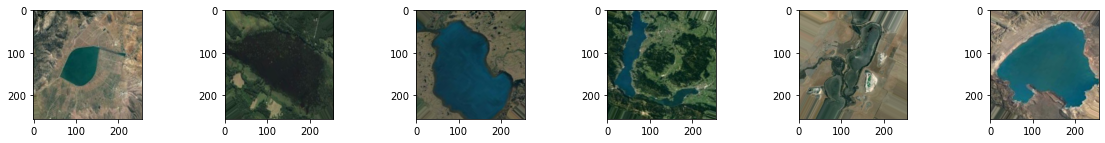

In [76]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [77]:
unet_large = Unet('unet-large', image_size, version=2)
model_name = unet_large.model_name
unet_large.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

The summary of this more robust model with more than 26 million parameters can be find detailed below.

In [78]:
unet_large.get_model_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 256, 256, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_81[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_82[0][0]                  
_______________________________________________________________________________________

#### Evaluating the model before training

In [79]:
X_test, Y_test = next(test_generator)
metrics = unet_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6853423118591309
IoU: 0.10369130223989487
IoU loss: 0.8963087201118469
Dice coeficient: 0.2558687627315521
Dice coeficient loss: 0.7441312670707703


#### Setup callbacks and fit the model

In [80]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_large.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_large.history

Epoch 1/200
61/61 [==============================] - 26s 419ms/step - loss: 0.4176 - mean_iou: 0.1279 - iou_loss: 0.8721 - dice_coef: 0.3712 - dice_coef_loss: 0.6288 - val_loss: 0.3229 - val_mean_iou: 0.6304 - val_iou_loss: 0.3696 - val_dice_coef: 0.4659 - val_dice_coef_loss: 0.5341
Epoch 2/200
61/61 [==============================] - 24s 390ms/step - loss: 0.2994 - mean_iou: 0.5853 - iou_loss: 0.4147 - dice_coef: 0.5735 - dice_coef_loss: 0.4265 - val_loss: 0.2415 - val_mean_iou: 0.6292 - val_iou_loss: 0.3708 - val_dice_coef: 0.6257 - val_dice_coef_loss: 0.3743
Epoch 3/200
61/61 [==============================] - 24s 393ms/step - loss: 0.2378 - mean_iou: 0.6578 - iou_loss: 0.3422 - dice_coef: 0.6644 - dice_coef_loss: 0.3356 - val_loss: 0.1958 - val_mean_iou: 0.7074 - val_iou_loss: 0.2926 - val_dice_coef: 0.7292 - val_dice_coef_loss: 0.2708
Epoch 4/200
61/61 [==============================] - 24s 389ms/step - loss: 0.2424 - mean_iou: 0.6598 - iou_loss: 0.3402 - dice_coef: 0.6900 - dice_

#### Inspect and save the history

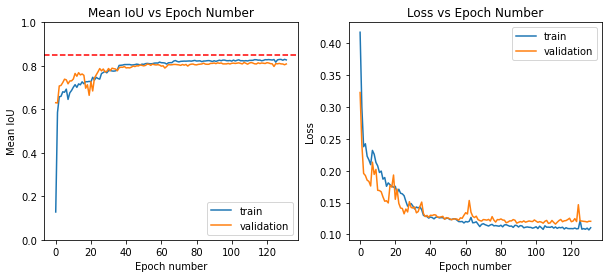

In [81]:
plot_history(unet_large.history)
save_model_history(model_name, unet_large.history)

#### Evaluating the model after training

In [82]:
metrics = unet_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.4913594126701355
IoU: 0.5105298161506653
IoU loss: 0.48947012424468994
Dice coeficient: 0.6405670642852783
Dice coeficient loss: 0.3594329059123993


Delete the model.

In [83]:
del unet_large

### Optimization strategy 3.1: Changing baseline architecture using a batch normalization

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [84]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

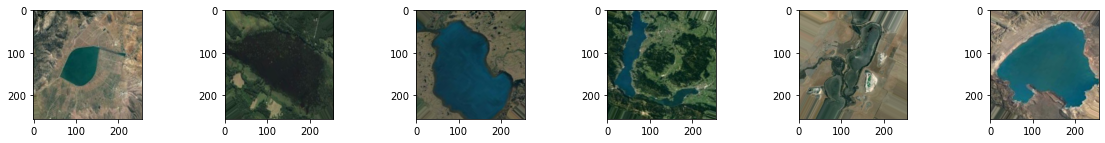

In [85]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [86]:
unet_batch_normalization = Unet('unet-batch-normalization', image_size, version=3)
model_name = unet_batch_normalization.model_name
unet_batch_normalization.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

The summary of this architecture with batch normalization can be find detailed below.

In [87]:
unet_batch_normalization.get_model_summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 256, 256, 8)  224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 256, 256, 8)  584         conv2d_108[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d_109[0][0]                 
_______________________________________________________________________________________

#### Evaluating the model before training

In [88]:
X_test, Y_test = next(test_generator)
metrics = unet_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.7074267268180847
IoU: 0.15896284580230713
IoU loss: 0.8410370349884033
Dice coeficient: 0.2402482032775879
Dice coeficient loss: 0.7597517967224121


#### Setup callbacks and fit the model

In [89]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_batch_normalization.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_batch_normalization.history

Epoch 1/200
61/61 [==============================] - 14s 221ms/step - loss: 0.3987 - mean_iou: 0.4352 - iou_loss: 0.5648 - dice_coef: 0.5059 - dice_coef_loss: 0.4941 - val_loss: 0.4699 - val_mean_iou: 0.0630 - val_iou_loss: 0.9370 - val_dice_coef: 0.3131 - val_dice_coef_loss: 0.6869
Epoch 2/200
61/61 [==============================] - 13s 218ms/step - loss: 0.2359 - mean_iou: 0.6721 - iou_loss: 0.3279 - dice_coef: 0.6954 - dice_coef_loss: 0.3046 - val_loss: 0.4257 - val_mean_iou: 0.0751 - val_iou_loss: 0.9249 - val_dice_coef: 0.3045 - val_dice_coef_loss: 0.6955
Epoch 3/200
61/61 [==============================] - 13s 218ms/step - loss: 0.2031 - mean_iou: 0.7025 - iou_loss: 0.2975 - dice_coef: 0.7337 - dice_coef_loss: 0.2663 - val_loss: 0.3721 - val_mean_iou: 0.1545 - val_iou_loss: 0.8455 - val_dice_coef: 0.3866 - val_dice_coef_loss: 0.6134
Epoch 4/200
61/61 [==============================] - 13s 215ms/step - loss: 0.2043 - mean_iou: 0.7085 - iou_loss: 0.2915 - dice_coef: 0.7455 - dice_

#### Inspect and save the history

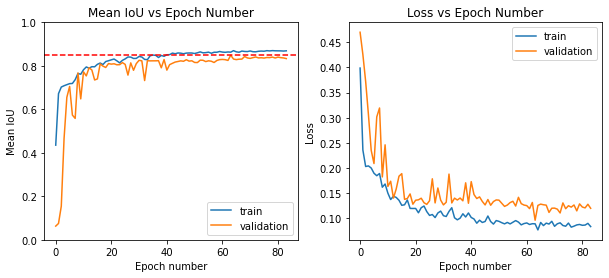

In [90]:
plot_history(unet_batch_normalization.history)
save_model_history(model_name, unet_batch_normalization.history)

#### Evaluating the model after training

In [91]:
metrics = unet_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.32029134035110474
IoU: 0.5685973167419434
IoU loss: 0.43140268325805664
Dice coeficient: 0.6925869584083557
Dice coeficient loss: 0.3074129521846771


Delete the model.

In [92]:
del unet_batch_normalization

### Optimization strategy 3.2: Changing large architecture using a batch normalization

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [93]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

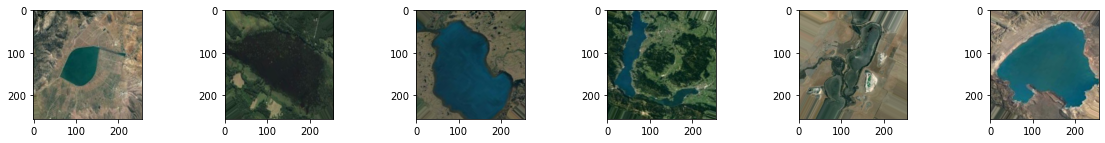

In [94]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [95]:
unet_large_batch_normalization = Unet('unet-batch-normalization-large', image_size, version=4)
model_name = unet_large_batch_normalization.model_name
unet_large_batch_normalization.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

In [96]:
unet_large_batch_normalization.get_model_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_135[0][0]                 
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 256, 256, 16) 64          conv2d_136[0][0]                 
______________________________________________________________________________________

#### Evaluating the model before training

In [97]:
X_test, Y_test = next(test_generator)
metrics = unet_large_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6947438716888428
IoU: 0.15302032232284546
IoU loss: 0.8469796776771545
Dice coeficient: 0.2647474706172943
Dice coeficient loss: 0.7352525591850281


#### Setup callbacks and fit the model

In [98]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_large_batch_normalization.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_large_batch_normalization.history

Epoch 1/200
61/61 [==============================] - 25s 408ms/step - loss: 0.3099 - mean_iou: 0.5293 - iou_loss: 0.4707 - dice_coef: 0.6059 - dice_coef_loss: 0.3941 - val_loss: 0.5662 - val_mean_iou: 3.4451e-04 - val_iou_loss: 0.9997 - val_dice_coef: 0.2847 - val_dice_coef_loss: 0.7153
Epoch 2/200
61/61 [==============================] - 25s 405ms/step - loss: 0.2425 - mean_iou: 0.6781 - iou_loss: 0.3219 - dice_coef: 0.6948 - dice_coef_loss: 0.3052 - val_loss: 0.4258 - val_mean_iou: 0.3381 - val_iou_loss: 0.6619 - val_dice_coef: 0.3798 - val_dice_coef_loss: 0.6202
Epoch 3/200
61/61 [==============================] - 24s 392ms/step - loss: 0.2046 - mean_iou: 0.6977 - iou_loss: 0.3023 - dice_coef: 0.7366 - dice_coef_loss: 0.2634 - val_loss: 0.5405 - val_mean_iou: 0.0025 - val_iou_loss: 0.9975 - val_dice_coef: 0.1812 - val_dice_coef_loss: 0.8188
Epoch 4/200
61/61 [==============================] - 24s 392ms/step - loss: 0.2026 - mean_iou: 0.7078 - iou_loss: 0.2922 - dice_coef: 0.7393 - d

#### Inspect and save the history

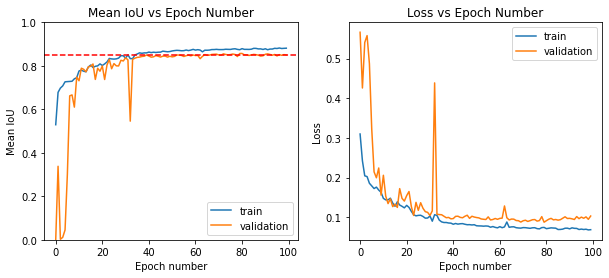

In [99]:
plot_history(unet_large_batch_normalization.history)
save_model_history(model_name, unet_large_batch_normalization.history)

#### Evaluating the model after training

In [100]:
metrics = unet_large_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.34382522106170654
IoU: 0.6143398880958557
IoU loss: 0.3856600522994995
Dice coeficient: 0.7357271313667297
Dice coeficient loss: 0.2642728388309479


Delete the model.

In [101]:
del unet_large_batch_normalization

### Optimization strategy 4.1: Changing model architecture using residual connections

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [102]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

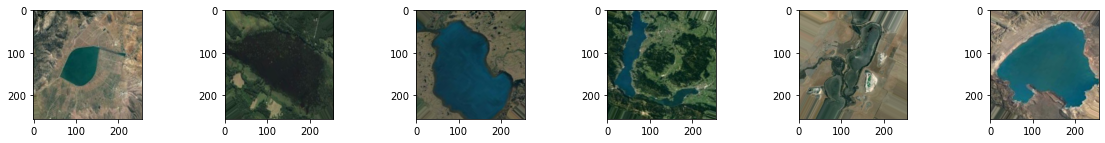

In [103]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [104]:
unet_residual = UnetResidual('unet-residual', image_size)
model_name = unet_residual.model_name
unet_residual.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

In [105]:
unet_residual.get_model_summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 256, 256, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 256, 256, 16) 64          conv2d_162[0][0]                 
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 256, 256, 16) 64          input_7[0][0]                    
______________________________________________________________________________________

#### Evaluating the model before training

In [106]:
X_test, Y_test = next(test_generator)
metrics = unet_residual.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6801915764808655
IoU: 0.2475643903017044
IoU loss: 0.7524356245994568
Dice coeficient: 0.25528931617736816
Dice coeficient loss: 0.7447106838226318


#### Setup callbacks and fit the model

In [107]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_residual.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual.history

Epoch 1/200
61/61 [==============================] - 18s 291ms/step - loss: 0.2694 - mean_iou: 0.6326 - iou_loss: 0.3674 - dice_coef: 0.6835 - dice_coef_loss: 0.3165 - val_loss: 2.5845 - val_mean_iou: 0.2338 - val_iou_loss: 0.7662 - val_dice_coef: 0.3882 - val_dice_coef_loss: 0.6118
Epoch 2/200
61/61 [==============================] - 17s 272ms/step - loss: 0.2051 - mean_iou: 0.7043 - iou_loss: 0.2957 - dice_coef: 0.7316 - dice_coef_loss: 0.2684 - val_loss: 0.4914 - val_mean_iou: 0.0574 - val_iou_loss: 0.9426 - val_dice_coef: 0.2988 - val_dice_coef_loss: 0.7012
Epoch 3/200
61/61 [==============================] - 16s 269ms/step - loss: 0.1892 - mean_iou: 0.7196 - iou_loss: 0.2804 - dice_coef: 0.7537 - dice_coef_loss: 0.2463 - val_loss: 0.6934 - val_mean_iou: 0.3026 - val_iou_loss: 0.6974 - val_dice_coef: 0.4334 - val_dice_coef_loss: 0.5666
Epoch 4/200
61/61 [==============================] - 16s 266ms/step - loss: 0.1792 - mean_iou: 0.7378 - iou_loss: 0.2622 - dice_coef: 0.7695 - dice_

#### Inspect and save the history

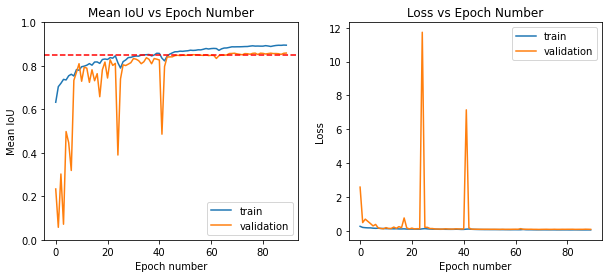

In [108]:
plot_history(unet_residual.history)
save_model_history(model_name, unet_residual.history)

#### Evaluating the model after training

In [109]:
metrics = unet_residual.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.5646527409553528
IoU: 0.4978199005126953
IoU loss: 0.5021800398826599
Dice coeficient: 0.6363650560379028
Dice coeficient loss: 0.3636349141597748


Delete the model.

In [110]:
del unet_residual

### Optimization strategy 4.2: Changing model architecture using residual connections and bigger filters

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [111]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

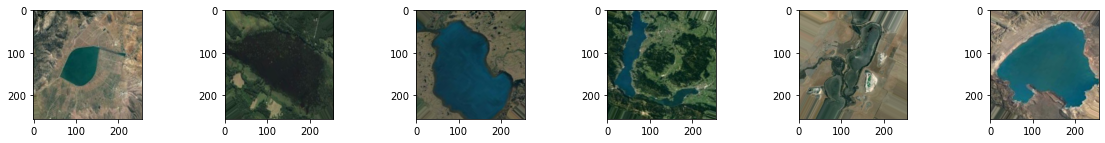

In [112]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [114]:
unet_residual_large = UnetResidual('unet-residual-large', image_size, version=2)
model_name = unet_residual_large.model_name
unet_residual_large.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

In [115]:
unet_residual_large.get_model_summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 256, 256, 32) 896         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 256, 256, 32) 128         conv2d_222[0][0]                 
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 256, 256, 32) 128         input_9[0][0]                    
______________________________________________________________________________________

#### Evaluating the model before training

In [116]:
X_test, Y_test = next(test_generator)
metrics = unet_residual_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6206366419792175
IoU: 2.3119740944821388e-05
IoU loss: 0.9999769330024719
Dice coeficient: 0.2579210698604584
Dice coeficient loss: 0.742078959941864


#### Setup callbacks and fit the model

In [117]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_residual_large.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual_large.history

Epoch 1/200
61/61 [==============================] - 38s 615ms/step - loss: 0.2515 - mean_iou: 0.6522 - iou_loss: 0.3478 - dice_coef: 0.7072 - dice_coef_loss: 0.2928 - val_loss: 1.0472 - val_mean_iou: 0.0369 - val_iou_loss: 0.9631 - val_dice_coef: 0.1175 - val_dice_coef_loss: 0.8825
Epoch 2/200
61/61 [==============================] - 36s 584ms/step - loss: 0.2134 - mean_iou: 0.6999 - iou_loss: 0.3001 - dice_coef: 0.7344 - dice_coef_loss: 0.2656 - val_loss: 1.5530 - val_mean_iou: 0.2506 - val_iou_loss: 0.7494 - val_dice_coef: 0.4040 - val_dice_coef_loss: 0.5960
Epoch 3/200
61/61 [==============================] - 36s 591ms/step - loss: 0.1882 - mean_iou: 0.7253 - iou_loss: 0.2747 - dice_coef: 0.7578 - dice_coef_loss: 0.2422 - val_loss: 1.0539 - val_mean_iou: 0.2614 - val_iou_loss: 0.7386 - val_dice_coef: 0.4212 - val_dice_coef_loss: 0.5788
Epoch 4/200
61/61 [==============================] - 35s 581ms/step - loss: 0.1957 - mean_iou: 0.7155 - iou_loss: 0.2845 - dice_coef: 0.7536 - dice_

#### Inspect and save the history

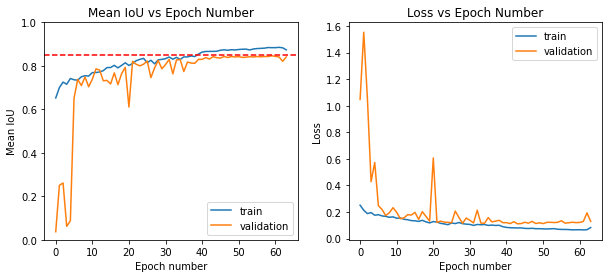

In [118]:
plot_history(unet_residual_large.history)
save_model_history(model_name, unet_residual_large.history)

#### Evaluating the model after training

In [ ]:
metrics = unet_residual_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.4154634475708008
IoU: 0.5329542756080627
IoU loss: 0.46704569458961487
Dice coeficient: 0.667233407497406
Dice coeficient loss: 0.3327666223049164


Delete the model.

In [ ]:
del unet_residual_large

### Optimization strategy 5.1: Dealing with class imbalance using dice loss

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [ ]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

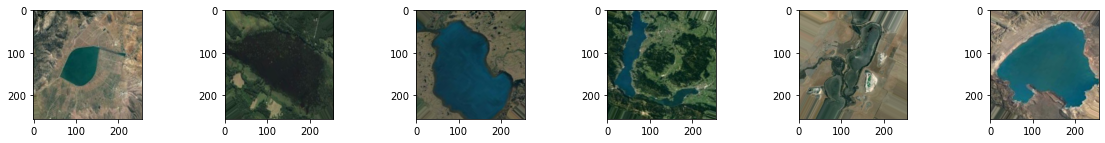

In [ ]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [ ]:
unet_residual_dice = UnetResidual('unet-residual-dice', image_size)
model_name = unet_residual_dice.model_name
unet_residual_dice.set_compiler(dice_coef_loss, metrics=[dice_coef], optimizer=model_optimizer)

#### Model summary

In [ ]:
unet_residual_dice.get_model_summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_252 (Conv2D)             (None, 256, 256, 16) 448         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 256, 256, 16) 64          conv2d_252[0][0]                 
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 256, 256, 16) 64          input_10[0][0]                   
______________________________________________________________________________________

#### Evaluating the model before training

In [ ]:
X_test, Y_test = next(test_generator)
metrics = unet_residual_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Dice coeficient loss: 0.7349977493286133
Dice coeficient: 0.25980257987976074


#### Setup callbacks and fit the model

In [ ]:
callback_parameters = build_callback_parameters(model_name, 'val_dice_coef')
callbacks = build_callbacks(callback_parameters)
unet_residual_dice.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual_dice.history

Epoch 1/200
61/61 [==============================] - 17s 274ms/step - loss: 0.2191 - dice_coef: 0.7782 - val_loss: 0.9990 - val_dice_coef: 0.0010
Epoch 2/200
61/61 [==============================] - 16s 268ms/step - loss: 0.1904 - dice_coef: 0.8096 - val_loss: 0.9997 - val_dice_coef: 3.4695e-04
Epoch 3/200
61/61 [==============================] - 16s 270ms/step - loss: 0.1692 - dice_coef: 0.8266 - val_loss: 0.9548 - val_dice_coef: 0.0452
Epoch 4/200
61/61 [==============================] - 16s 267ms/step - loss: 0.1563 - dice_coef: 0.8398 - val_loss: 0.5699 - val_dice_coef: 0.4301
Epoch 5/200
61/61 [==============================] - 16s 266ms/step - loss: 0.1428 - dice_coef: 0.8531 - val_loss: 0.1999 - val_dice_coef: 0.8001
Epoch 6/200
61/61 [==============================] - 16s 266ms/step - loss: 0.1487 - dice_coef: 0.8484 - val_loss: 0.1581 - val_dice_coef: 0.8419
Epoch 7/200
61/61 [==============================] - 16s 264ms/step - loss: 0.1425 - dice_coef: 0.8544 - val_loss: 0.257

#### Inspect and save the history

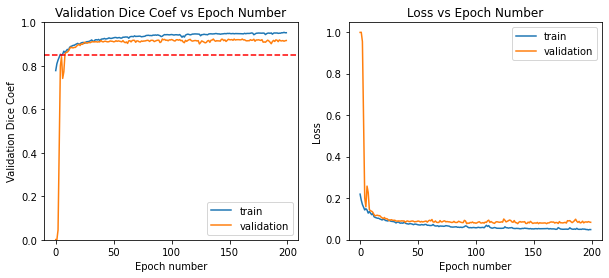

In [ ]:
plot_history(unet_residual_dice.history, metric='dice_coef')
save_model_history(model_name, unet_residual_dice.history)

#### Evaluating the model after training

In [ ]:
metrics = unet_residual_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Dice coeficient loss: 0.3779889941215515
Dice coeficient: 0.607271134853363


Delete the model.

In [ ]:
del unet_residual_dice

### Optimization strategy 5.2: Dealing with class imbalance using dice loss and a large network

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

#### Display a few samples from the training dataset

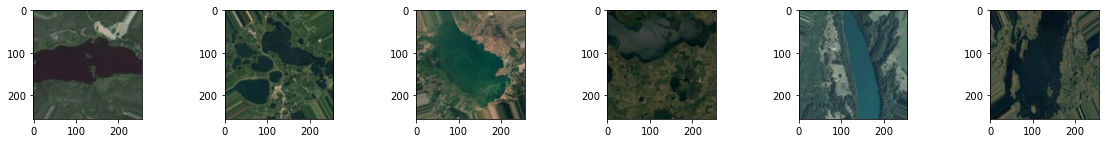

In [ ]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [ ]:
unet_residual_large_dice = UnetResidual('unet-residual-large-dice', image_size, version=2)
model_name = unet_residual_large_dice.model_name
unet_residual_large_dice.set_compiler(dice_coef_loss, metrics=[dice_coef], optimizer=model_optimizer)

#### Model summary

In [ ]:
unet_residual_large_dice.get_model_summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 256, 256, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 256, 256, 32) 128         conv2d_282[0][0]                 
__________________________________________________________________________________________________
conv2d_284 (Conv2D)             (None, 256, 256, 32) 128         input_11[0][0]                   
______________________________________________________________________________________

#### Evaluating the model before training

In [ ]:
X_test, Y_test = next(test_generator)
metrics = unet_residual_large_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Dice coeficient loss: 0.730883777141571
Dice coeficient: 0.264388769865036


#### Setup callbacks and fit the model

In [ ]:
callback_parameters = build_callback_parameters(model_name, 'val_dice_coef')
callbacks = build_callbacks(callback_parameters)
unet_residual_large_dice.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual_large_dice.history

Epoch 1/200
61/61 [==============================] - 36s 589ms/step - loss: 0.2228 - dice_coef: 0.7723 - val_loss: 0.6145 - val_dice_coef: 0.3855
Epoch 2/200
61/61 [==============================] - 35s 572ms/step - loss: 0.1924 - dice_coef: 0.8039 - val_loss: 0.6228 - val_dice_coef: 0.3772
Epoch 3/200
61/61 [==============================] - 35s 571ms/step - loss: 0.1847 - dice_coef: 0.8101 - val_loss: 0.9442 - val_dice_coef: 0.0558
Epoch 4/200
61/61 [==============================] - 35s 573ms/step - loss: 0.1729 - dice_coef: 0.8234 - val_loss: 0.9237 - val_dice_coef: 0.0763
Epoch 5/200
61/61 [==============================] - 35s 571ms/step - loss: 0.1806 - dice_coef: 0.8156 - val_loss: 0.7177 - val_dice_coef: 0.2823
Epoch 6/200
61/61 [==============================] - 35s 574ms/step - loss: 0.1718 - dice_coef: 0.8266 - val_loss: 0.3690 - val_dice_coef: 0.6310
Epoch 7/200
61/61 [==============================] - 35s 570ms/step - loss: 0.1666 - dice_coef: 0.8300 - val_loss: 0.3996 - 

#### Inspect and save the history

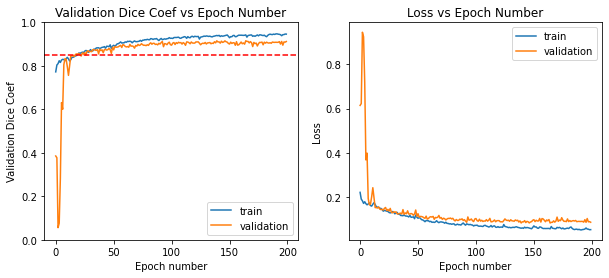

In [ ]:
plot_history(unet_residual_large_dice.history, metric='dice_coef')
save_model_history(model_name, unet_residual_large_dice.history)

#### Evaluating the model after training

In [ ]:
metrics = unet_residual_large_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Dice coeficient loss: 0.3422057628631592
Dice coeficient: 0.6720798015594482


Delete the model.

In [ ]:
del unet_residual_large_dice

## Compare the Results

### All models

#### Mean IoU

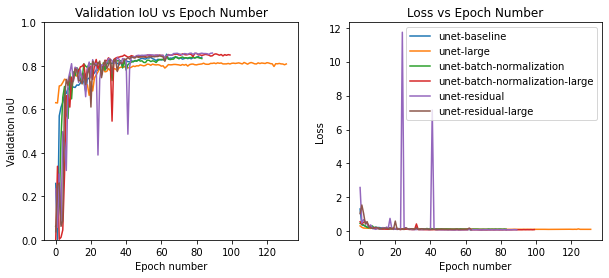

In [ ]:
histories_iou = {title: history for title, history in histories.items() if not title.endswith("dice")}
plot_histories(histories_iou)

#### Dice Loss

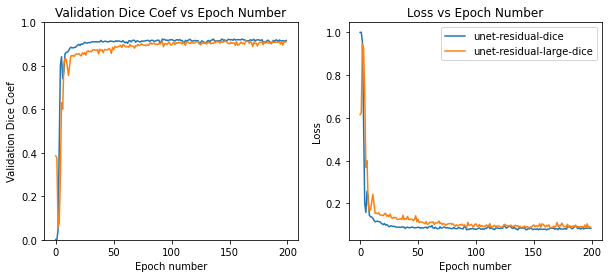

In [ ]:
histories_iou = {title: history for title, history in histories.items() if title.endswith("dice")}
plot_histories(histories_iou, metric='dice_coef')

### Overall metrics

In [ ]:
pprint.pprint(results, indent=2)

{ 'unet-baseline': { 'dice_coef': 0.754050076007843,
                     'dice_coef_loss': 0.2459498643875122,
                     'iou': 0.659829318523407,
                     'iou_loss': 0.34017065167427063,
                     'loss': 0.21110928058624268},
  'unet-batch-normalization': { 'dice_coef': 0.6925869584083557,
                                'dice_coef_loss': 0.3074129521846771,
                                'iou': 0.5685973167419434,
                                'iou_loss': 0.43140268325805664,
                                'loss': 0.32029134035110474},
  'unet-batch-normalization-large': { 'dice_coef': 0.7357271313667297,
                                      'dice_coef_loss': 0.2642728388309479,
                                      'iou': 0.6143398880958557,
                                      'iou_loss': 0.3856600522994995,
                                      'loss': 0.34382522106170654},
  'unet-large': { 'dice_coef': 0.6405670642852783,
              

Clean up temporary files and folders.

In [ ]:
training_folders = ['nwpu_images_train', 'nwpu_label_images_train']
validation_folders = ['nwpu_images_validation', 'nwpu_label_images_validation']
test_folders = ['s2cloudless_imagery', 's2cloudless_label_imagery']
[shutil.rmtree(folder) for folder in training_folders + validation_folders + test_folders]

[None, None, None, None, None, None]